## Projet : Analyse des Données Clients ##

Dans ce projet, nous allons explorer et nettoyer un dataset contenant des informations sur des clients.  L’objectif est double de chiffrer
l’efficacité des campagnes marketing et cerner la cible client.

### Importation des bibliothèques

Dans ce code, nous avons importé les bibliothèques nécessaires pour l'analyse des données, notamment pandas pour la manipulation des données, LabelEncoder et StandardScaler de sklearn.preprocessing pour le prétraitement des données, ainsi que matplotlib.pyplot et seaborn pour la visualisation. 

Nous avons également importé PCA et KMeans de sklearn.decomposition et sklearn.cluster respectivement, afin de réaliser une analyse en composantes principales et un clustering.

De plus, nous avons importé numpy pour les opérations numériques et statsmodels.api pour des analyses statistiques avancées.

Enfin, nous avons chargé les données à partir d'un fichier CSV nommé 'Camp_Market.csv', en spécifiant un point-virgule comme délimiteur.

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import statsmodels.api as sm

# Charger les données
data = pd.read_csv('Camp_Market.csv', delimiter=';')

### 1. Préparation des Données

Dans la première phase de nettoyage de la base de données, nous avons commencé par convertir la colonne Dt_Customer, qui contient des dates sous forme de chaînes, en un type de données datetime pour faciliter la manipulation des dates. 

Ensuite, nous avons vérifié la présence de valeurs manquantes dans le DataFrame, ce qui est essentiel pour comprendre la qualité des données et décider des actions à entreprendre. Pour garantir l'intégrité des données, nous avons supprimé toutes les lignes contenant des valeurs manquantes afin d'éviter des erreurs lors des analyses ultérieures.

Enfin, nous avons appliqué un filtre pour ne conserver que les clients qui se sont inscrits avant le 1er janvier 2015, permettant ainsi de se concentrer sur des données pertinentes et d'éviter les enregistrements récents qui pourraient ne pas être représentatifs des comportements des clients.

In [17]:
#   -----   Première phase de nettoyage de la base de données  -----

# Convertir la colonne 'Dt_Customer' en type datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%Y-%m-%d')

# Vérifier les valeurs manquantes
missing_values = data.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

# Suppression des lignes avec des valeurs manquantes
data = data.dropna()

# Filtrer les clients inscrits entre la date de création du CSV et le 1er janvier 2015
date_threshold = pd.to_datetime('2015-01-01')
data = data[data['Dt_Customer'] < date_threshold]


Valeurs manquantes par colonne :
Income    24
dtype: int64


### 2. Créer des variables age, spent, living with, children, family_size ,is_parent, education2, customer_for et éliminer les redondances occasionnées

Dans cette section, nous avons créé plusieurs variables supplémentaires pour enrichir notre jeu de données. 

Tout d'abord, nous avons calculé l'âge actuel des clients en soustrayant leur année de naissance de 2015. Ensuite, nous avons ajouté une colonne représentant le montant total dépensé par chaque client sur deux ans, en faisant la somme des colonnes correspondantes aux dépenses. Nous avons également simplifié le statut marital en une catégorie binaire : "Célibataire" pour les personnes seules et "En couple" pour les mariés ou en couple. 

De plus, nous avons calculé le nombre total d'enfants en additionnant les enfants à domicile et les adolescents, puis déterminé la taille du foyer en ajoutant 1 pour inclure le client lui-même et en tenant compte du statut marital. Un indicateur de statut parental a été créé, où 0 signifie "non" et 1 "oui", en fonction du nombre d'enfants.

Nous avons simplifié le niveau d'éducation en regroupant certaines catégories en "Undergrad", "Grad" et "Postgrad". Nous avons également calculé le nombre de jours depuis que le client a commencé ses achats, en utilisant la date la plus récente d'achat.

Ensuite, nous avons défini une liste de colonnes à supprimer, incluant des informations jugées inutiles, et avons supprimé ces colonnes du DataFrame. Avant et après la suppression des colonnes, nous avons affiché le nombre de lignes dans le DataFrame, et enfin, nous avons affiché l'ensemble des colonnes restantes.


In [18]:
#   -----   Création des variables supplémentaires  -----

# Calcule de l'âge du client (âge actuel)
data['age'] = 2015 - data['Year_Birth']
 
# Calcule du  montant total dépensé par le client sur 2 ans
spent_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
data['spent'] = data[spent_columns].sum(axis=1)

# Statut simplifié : célibataire/en couple
def living_status(marital_status):
    if marital_status in ['Single', 'Divorced', 'Widow', 'Alone']:
        return 'Célibataire'
    elif marital_status in ['Married', 'Together']:
        return 'En couple'
 
data['living_with'] = data['Marital_Status'].apply(living_status)
 
# Nombre total d'enfants
data['children'] = data['Kidhome'] + data['Teenhome']
 
# Taille du foyer
data['family_size'] = data['children'] + 1  # +1 pour inclure le client lui-même
data['family_size'] += data['Marital_Status'].apply(lambda x: 1 if x in ['Married', 'Together'] else 0)
 
# Statut parent (0 = non, 1 = oui)
data['is_parent'] = data['children'].apply(lambda x: 1 if x > 0 else 0)
 
# Simplification du niveau d'éducation
def simplify_education(edu):
    if edu in ['2n Cycle', 'Basic']:
        return 'Undergrad'
    elif edu == 'Graduation':
        return 'Grad'
    else:
        return 'Postgrad'
 
data['education2'] = data['Education'].apply(simplify_education)
 
# Calcul du nombre de jours depuis que le client a commencé ses achats
latest_date = data['Dt_Customer'].max()
data['customer_for'] = (latest_date - data['Dt_Customer']).dt.days


# Liste des colonnes à supprimer
columns_to_drop = [
    'Z_Revenue', 'Education', 'Year_Birth', 'Z_CostContact', 'Marital_Status',
    'Kidhome', 'Teenhome', 'ID'
] 

# Suppression des colonnes inutiles
data = data.drop(columns=columns_to_drop, axis=1)

# Afficher le nombre de lignes avant la suppression
print("Nombre de lignes avant la suppression :", data.shape[0])

# Supprimer les lignes où l'âge est inférieur à 20 ou supérieur à 80
data_cleaned = data[(data['age'] >= 20) & (data['age'] <= 80)]

# Afficher le nombre de lignes après la suppression
print("Nombre de lignes après la suppression :", data_cleaned.shape[0])

# Afficher l'ensemble des colonnes
print(data.columns.tolist())


# Calculer la moyenne et l'écart type d'origine
original_mean = data['age'].mean()  # Moyenne d'origine
original_std = data['age'].std()     # Écart type d'origine

Nombre de lignes avant la suppression : 2216
Nombre de lignes après la suppression : 2211
['Income', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'age', 'spent', 'living_with', 'children', 'family_size', 'is_parent', 'education2', 'customer_for']


### 3. Analyse descriptive et exploratoire

Dans cette section, nous avons effectué une analyse descriptive et exploratoire des données. Nous avons affiché des statistiques descriptives pour l'âge, le montant dépensé, le nombre d'enfants et d'autres variables. 

Nous avons calculé la dépense moyenne par client et le taux de réponse. Des histogrammes ont été créés pour visualiser la distribution de l'âge et du montant total dépensé. Nous avons également examiné le revenu total par segment parental, la fréquence d'achat, la récence moyenne, et évalué le taux de satisfaction.

Des visualisations supplémentaires incluent des boxplots pour les dépenses par statut de vie, des barplots pour les dépenses selon le nombre d'enfants, et des countplots pour le statut de parent et le niveau d'éducation. Enfin, nous avons analysé la distribution du nombre de jours depuis l'inscription.

               age        spent     children  family_size  customer_for
count  2216.000000  2216.000000  2216.000000  2216.000000   2216.000000
mean     46.179603   607.075361     0.947202     2.592509    353.521209
std      11.985554   602.900476     0.749062     0.905722    202.434667
min      19.000000     5.000000     0.000000     1.000000      0.000000
25%      38.000000    69.000000     0.000000     2.000000    180.000000
50%      45.000000   396.500000     1.000000     3.000000    355.500000
75%      56.000000  1048.000000     1.000000     3.000000    529.000000
max     122.000000  2525.000000     3.000000     5.000000    699.000000
Dépense Moyenne par Client : 607.08
Taux de Réponse : 15.03%


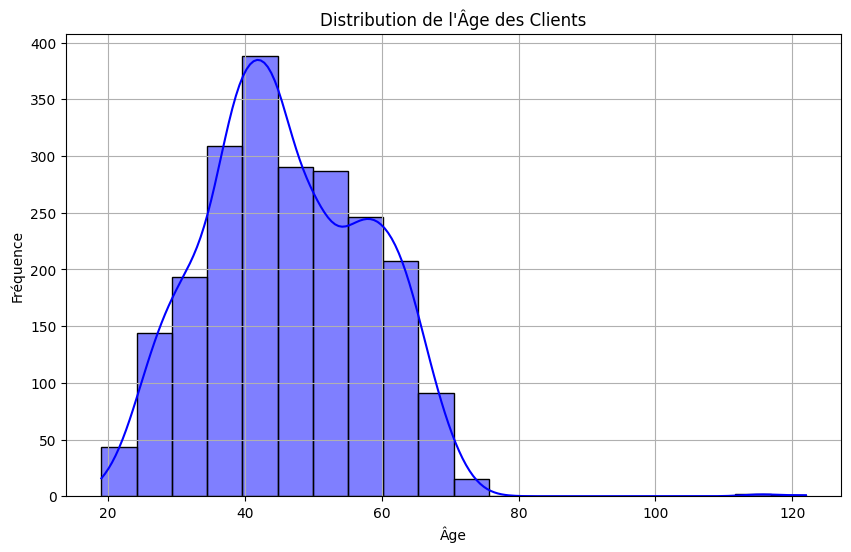

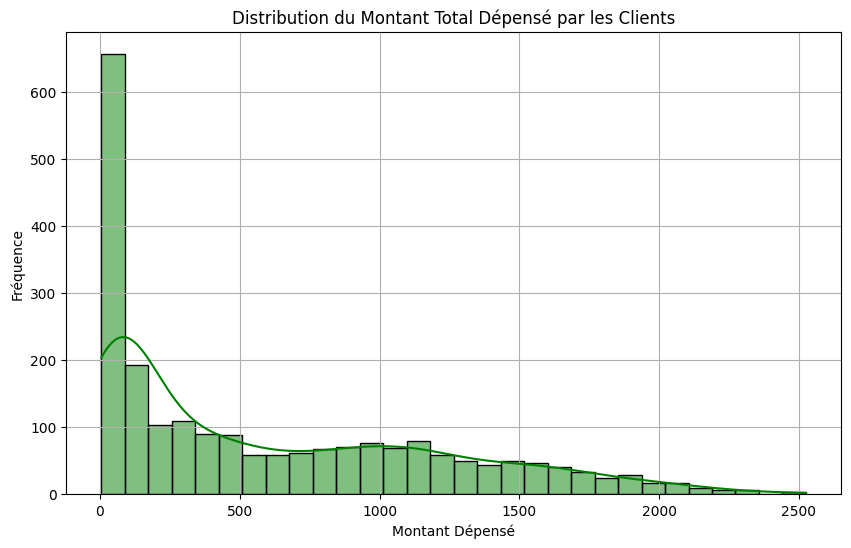


Revenu Total par Segment :
is_parent
0    699622
1    645657
Name: spent, dtype: int64
Fréquence d'Achat Moyenne : 4.09
Récence Moyenne : 49.01 jours
Taux de Satisfaction : 0.95%


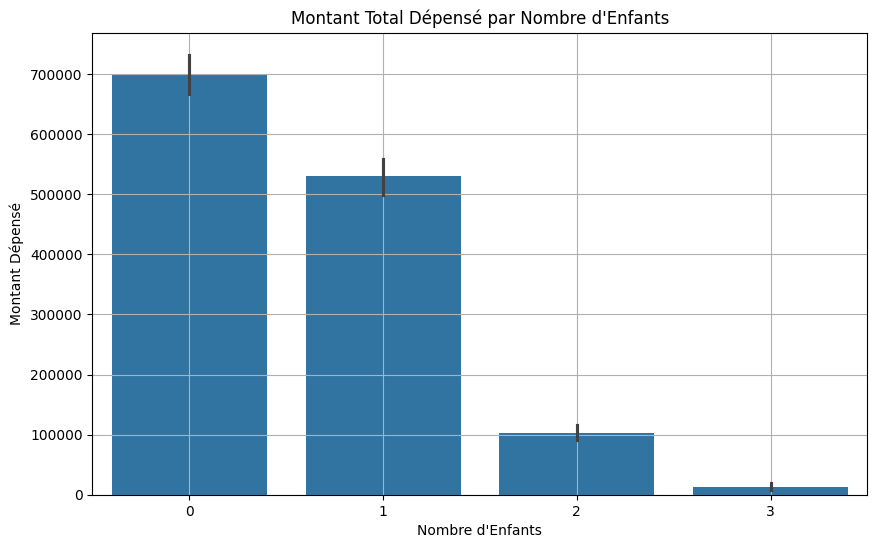

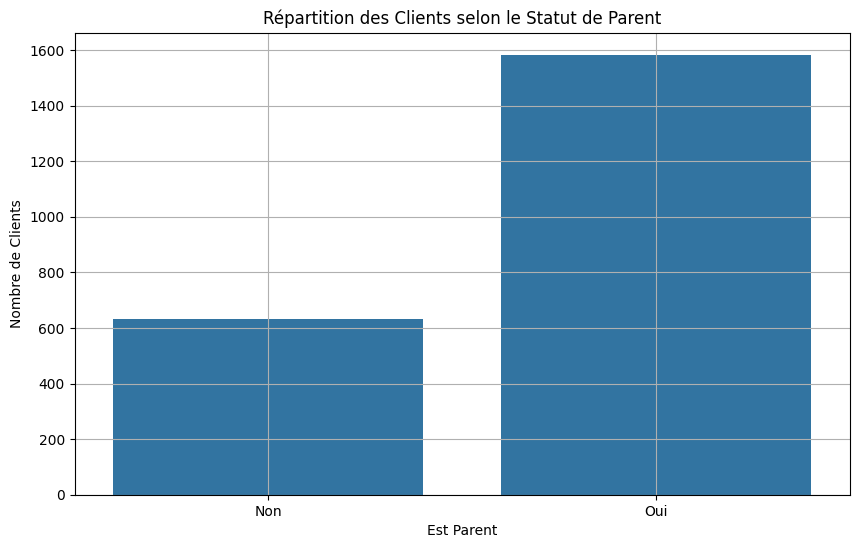

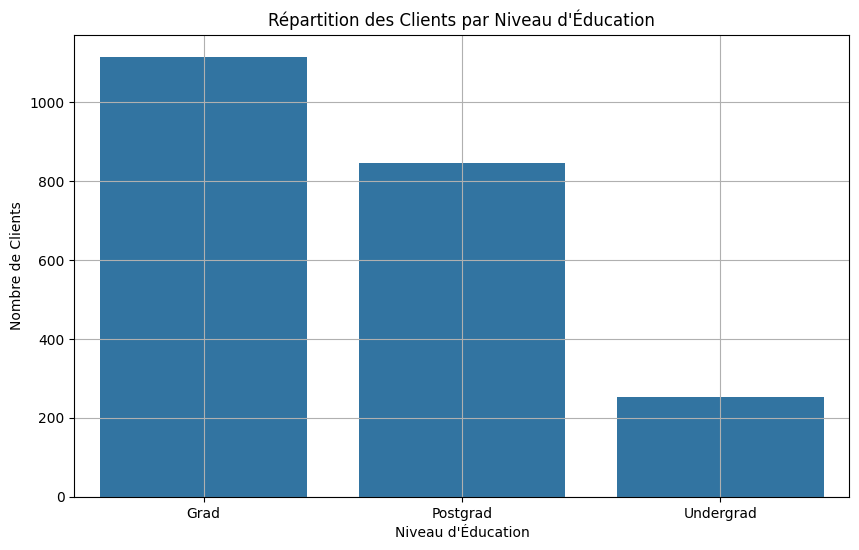

Taux d'acceptation par campagne (%):
AcceptedCmp1     6.407942
AcceptedCmp2     1.353791
AcceptedCmp3     7.355596
AcceptedCmp4     7.400722
AcceptedCmp5     7.310469
Response        15.027076
dtype: float64


/var/folders/ty/5wqjjz_n4_37mk583lfbl3r80000gn/T/ipykernel_1198/500428936.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acceptance_rates.index, y=acceptance_rates.values, palette='viridis')


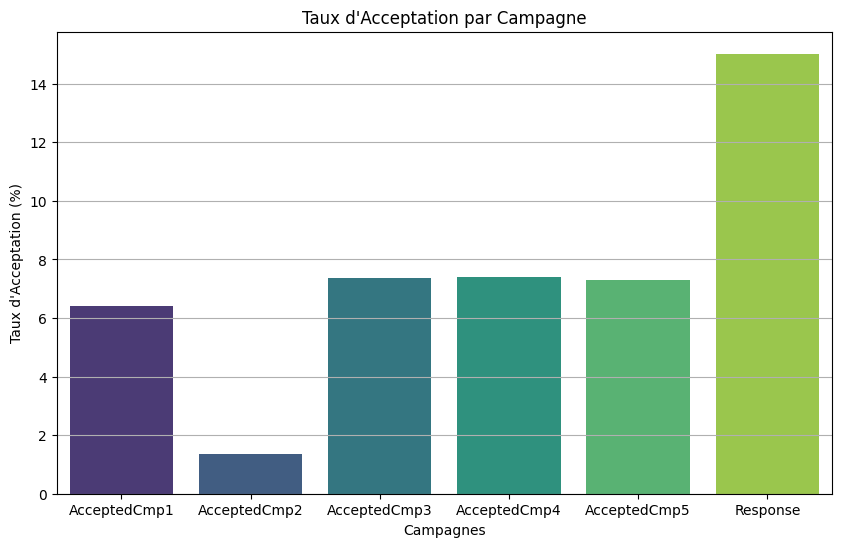

In [19]:
# ---- Analyse descriptive et exploratoire pertinente ----

# Statistiques descriptives
print(data[['age', 'spent', 'children', 'family_size', 'customer_for']].describe())

# Dépense Moyenne par Client
average_spend = data['spent'].mean()
print(f'Dépense Moyenne par Client : {average_spend:.2f}')


# Taux de Réponse
response_rate = (data['Response'].sum() / len(data)) * 100
print(f'Taux de Réponse : {response_rate:.2f}%')


# Distribution de l'Âge
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=20, kde=True, color='blue')
plt.title('Distribution de l\'Âge des Clients')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.grid()
plt.show()

# Montant Total Dépensé
plt.figure(figsize=(10, 6))
sns.histplot(data['spent'], bins=30, kde=True, color='green')
plt.title('Distribution du Montant Total Dépensé par les Clients')
plt.xlabel('Montant Dépensé')
plt.ylabel('Fréquence')
plt.grid()
plt.show()

# Revenu Total par Segment
revenue_per_segment = data.groupby('is_parent')['spent'].sum()
print("\nRevenu Total par Segment :")
print(revenue_per_segment)


# Fréquence d'Achat
purchase_frequency = data['NumWebPurchases'].mean()
print(f'Fréquence d\'Achat Moyenne : {purchase_frequency:.2f}')


# Récence
recency = data['Recency'].mean()
print(f'Récence Moyenne : {recency:.2f} jours')


# Taux de Satisfaction
satisfaction_rate = (data['Complain'].sum() / len(data)) * 100
print(f'Taux de Satisfaction : {satisfaction_rate:.2f}%')


# Montant Dépensé par Nombre d'Enfants
plt.figure(figsize=(10, 6))
sns.barplot(x='children', y='spent', data=data, estimator=sum)
plt.title('Montant Total Dépensé par Nombre d\'Enfants')
plt.xlabel('Nombre d\'Enfants')
plt.ylabel('Montant Dépensé')
plt.grid()
plt.show()

# Indicateur de Parentalité
plt.figure(figsize=(10, 6))
sns.countplot(x='is_parent', data=data)
plt.title('Répartition des Clients selon le Statut de Parent')
plt.xlabel('Est Parent')
plt.ylabel('Nombre de Clients')
plt.xticks([0, 1], ['Non', 'Oui'])
plt.grid()
plt.show()

# Niveau d'Éducation
plt.figure(figsize=(10, 6))
sns.countplot(x='education2', data=data)
plt.title('Répartition des Clients par Niveau d\'Éducation')
plt.xlabel('Niveau d\'Éducation')
plt.ylabel('Nombre de Clients')
plt.grid()
plt.show()

# Liste des colonnes des campagnes, y compris la colonne 'Response'
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

# Calculer le taux d'acceptation pour chaque campagne
acceptance_rates = data[campaign_columns].mean() * 100  # Multiplier par 100 pour obtenir un pourcentage

# Afficher les résultats
print("Taux d'acceptation par campagne (%):")
print(acceptance_rates)

# Visualiser les taux d'acceptation par campagne
plt.figure(figsize=(10, 6))
sns.barplot(x=acceptance_rates.index, y=acceptance_rates.values, palette='viridis')
plt.title('Taux d\'Acceptation par Campagne')
plt.xlabel('Campagnes')
plt.ylabel('Taux d\'Acceptation (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


### 4. Matrice de corrélation

Dans cette section, nous avons créé une matrice de corrélation pour analyser les relations entre diverses variables d'intérêt. Nous avons sélectionné des variables telles que le revenu, la récence, les montants dépensés par catégorie de produit, ainsi que des indicateurs de comportement d'achat et de satisfaction. 

Après avoir calculé la matrice de corrélation, nous l'avons visualisée à l'aide d'une carte thermique (heatmap). Cette visualisation permet d'identifier rapidement les relations positives et négatives entre les variables, offrant ainsi des insights précieux sur les comportements des clients.


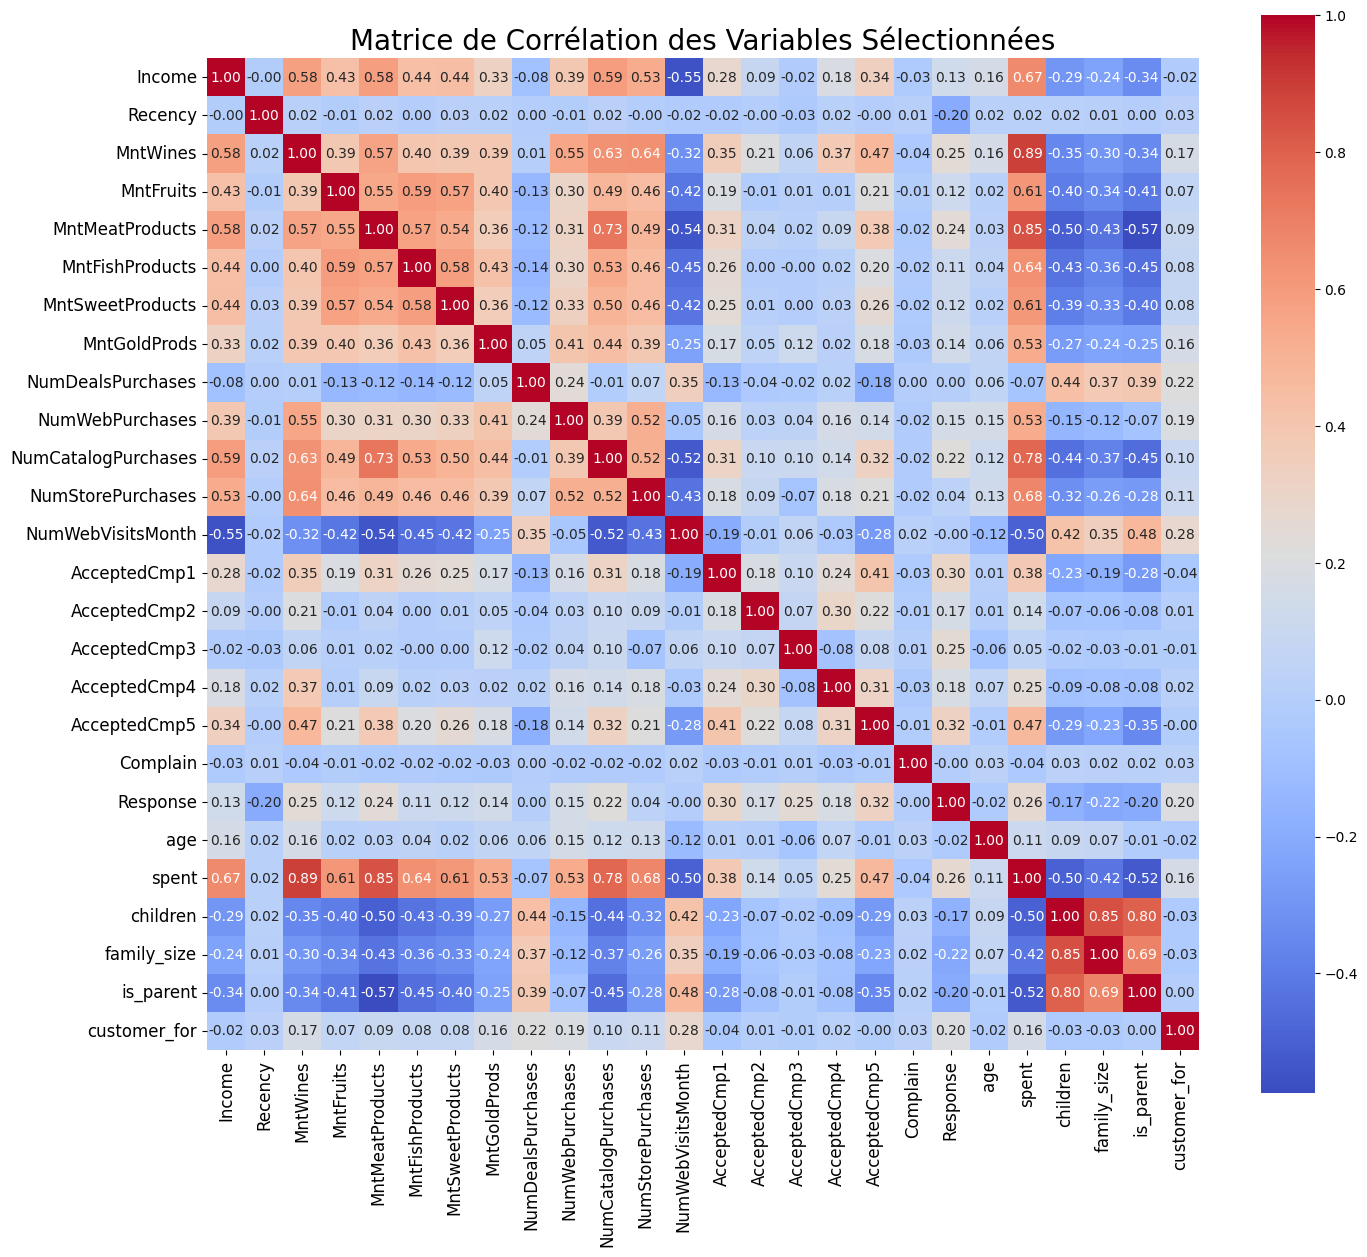

In [20]:
# ---- Matricde de corrélation ----

# Sélection des variables pour la matrice de corrélation
variables_of_interest = [
    'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
    'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp1', 
    'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
    'Complain', 'Response', 'age', 'spent', 'children', 
    'family_size', 'is_parent', 'customer_for'
]

# Calculer la matrice de corrélation
correlation_matrix = data[variables_of_interest].corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(16, 14))  # Augmenter la taille de la figure
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, annot_kws={"size": 10})
plt.title('Matrice de Corrélation des Variables Sélectionnées', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### 4. Preprocessing
 
 Nous avons réencodé les variables catégorielles en utilisant LabelEncoder pour transformer les colonnes living_with et education2 en valeurs numériques. Ensuite, nous avons appliqué une normalisation sur l'ensemble des données numériques à l'aide de StandardScaler, ce qui permet d'assurer que toutes les caractéristiques ont une moyenne de 0 et un écart type de 1. Cette étape est essentielle pour préparer les données avant d'appliquer des modèles de machine learning.


In [21]:
# ---- Phase de preprocessing ----

# Réencoder les variables catégorielles
label_encoder = LabelEncoder()
data['living_with'] = label_encoder.fit_transform(data['living_with'])
data['education2'] = label_encoder.fit_transform(data['education2'])

# Créer une copie du DataFrame pour la standardisation
data_scaled = data.copy()

# Identifier les colonnes numériques
numeric_features = data_scaled.select_dtypes(include=[np.number]).columns.tolist()

# Appliquer le scaling uniquement sur les colonnes numériques de la copie
scaler = StandardScaler()
data_scaled[numeric_features] = scaler.fit_transform(data_scaled[numeric_features])

# Vérifier les résultats
print("Données d'origine (premières lignes) :")
print(data.head())

print("\nDonnées standardisées (premières lignes) :")
print(data_scaled.head())

Données d'origine (premières lignes) :
    Income Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
0  58138.0  2012-09-04       58       635         88              546   
1  46344.0  2014-03-08       38        11          1                6   
2  71613.0  2013-08-21       26       426         49              127   
3  26646.0  2014-02-10       26        11          4               20   
4  58293.0  2014-01-19       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  ...  \
0              172                88            88                  3  ...   
1                2                 1             6                  2  ...   
2              111                21            42                  1  ...   
3               10                 3             5                  2  ...   
4               46                27            15                  5  ...   

   Complain  Response  age  spent  living_with  child

### 5. PCA

Dans cette section, nous avons appliqué l'analyse en composantes principales (PCA) pour réduire la dimensionnalité des données tout en conservant l'essentiel de l'information. Nous avons spécifié que nous souhaitions extraire trois composantes principales, puis nous avons transformé les données numériques en ces nouvelles dimensions. Ensuite, nous avons visualisé les résultats en créant un graphique 3D, où chaque point représente une observation projetée sur les trois premières composantes principales. Cette visualisation permet d'identifier des clusters potentiels et d'explorer la structure sous-jacente des données.

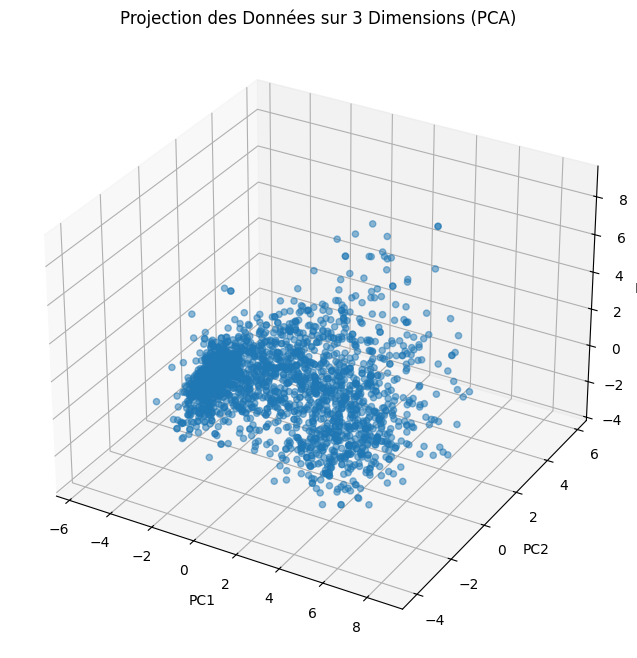

In [22]:
# ---- PCA ----

# Appliquer PCA sur les données standardisées
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data_scaled[numeric_features])

# Créer un DataFrame pour les composantes principales
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Visualiser les résultats
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], alpha=0.5)
ax.set_title('Projection des Données sur 3 Dimensions (PCA)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()



### 6. Kmeans

#### Détermination du meilleur K

Dans cette section, nous avons utilisé la méthode du coude pour déterminer le nombre optimal de clusters pour l'algorithme K-Means. Nous avons testé un éventail de valeurs de 1 à 10 clusters, en calculant l'inertie pour chaque valeur. L'inertie, qui mesure la somme des distances au carré entre les points et leur centre de cluster, nous aide à évaluer la compacité des clusters formés. Après avoir exécuté l'algorithme K-Means pour chaque nombre de clusters, nous avons visualisé les résultats à l'aide d'un graphique, montrant l'inertie en fonction du nombre de clusters. Cette visualisation permet d'identifier le point où l'inertie commence à diminuer de manière marginale, indiquant le nombre optimal de clusters à choisir.


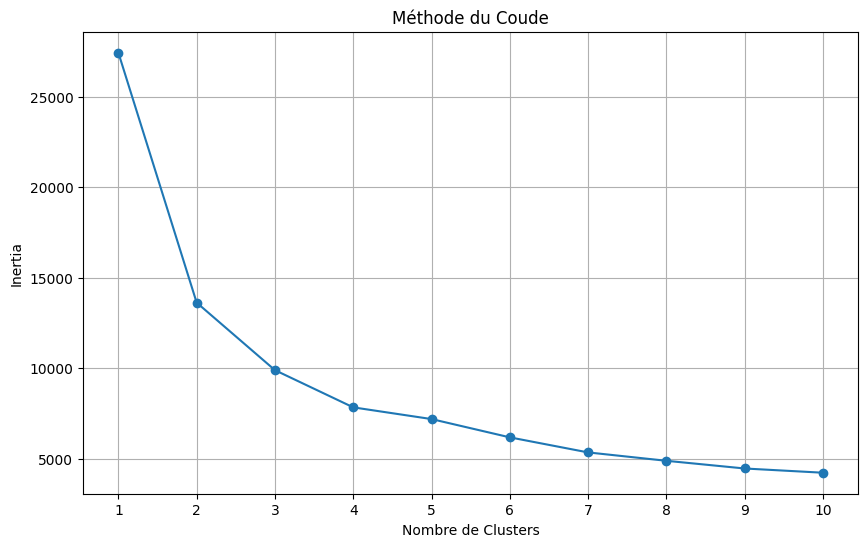

In [23]:
# ---- Kmeans ----

# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
K = range(1, 11)  # Tester de 1 à 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)

# Visualiser la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertia')
plt.xticks(K)
plt.grid()
plt.show()


### 6. Kmeans

#### Visualisation des clusters

Dans cette section, nous avons choisi d'utiliser 3 clusters comme nombre optimal pour l'algorithme K-Means. Après avoir ajusté le modèle sur les données transformées par PCA, nous avons ajouté les labels des clusters au DataFrame original. Pour visualiser les résultats, nous avons créé un graphique 3D où chaque point représente une observation projetée sur les trois premières composantes principales, coloré selon son cluster attribué. Cette visualisation permet de mieux comprendre la distribution des clusters dans l'espace réduit, facilitant ainsi l'analyse des groupes de données identifiés par K-Means.

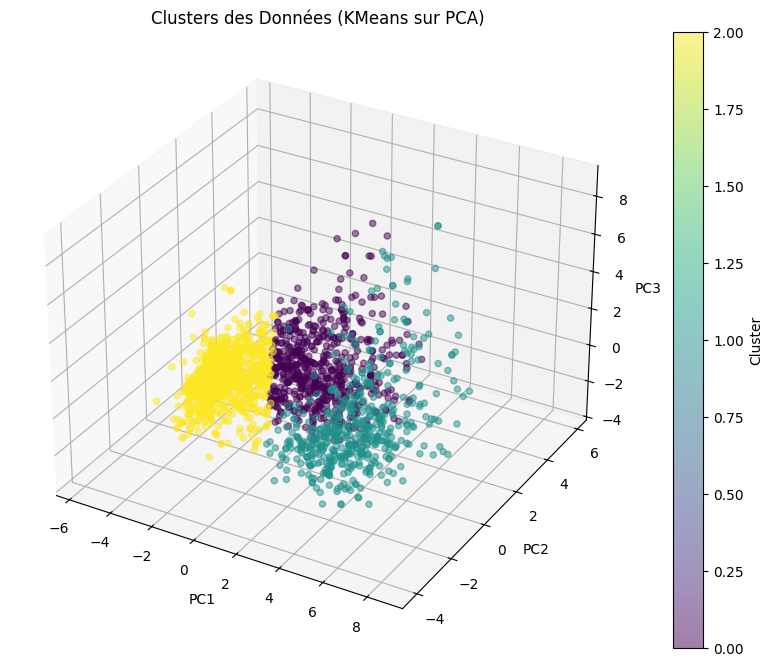

In [24]:
# ---- Kmeans ----

# Choisir le nombre de clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(pca_df)

# Ajouter les labels des clusters au DataFrame d'origine
data['Cluster'] = kmeans.labels_

# Visualiser les clusters en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=data['Cluster'], cmap='viridis', alpha=0.5)
ax.set_title('Clusters des Données (KMeans sur PCA)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Ajouter la barre de couleur
plt.colorbar(scatter, label='Cluster')
plt.show()


### 7. Évaluation des modèles et interprétation du profil consommateur

Dans cette section, nous avons évalué les modèles et interprété le profil des consommateurs en analysant les clusters obtenus. Nous avons commencé par compter le nombre de clients dans chaque cluster et visualisé cette répartition à l'aide d'un diagramme circulaire. Ensuite, nous avons créé un diagramme de dispersion pour examiner les dépenses par rapport au revenu, en colorant les points selon leur cluster. Des boxplots ont été utilisés pour illustrer la distribution des dépenses par cluster et pour comparer les dépenses selon le statut parental au sein de chaque cluster. Nous avons également calculé et visualisé les taux d'acceptation des campagnes marketing par cluster à l'aide d'un barplot, suivi d'une analyse des dépenses par type de produit. L'âge moyen des clients par cluster a été calculé et visualisé avec un barplot, permettant de mieux comprendre la démographie de chaque groupe. Enfin, nous avons utilisé des countplots pour visualiser la répartition des clients en couple ou célibataire, ainsi que la présence d'enfants, fournissant ainsi une vue d'ensemble complète des caractéristiques des consommateurs au sein des différents clusters.

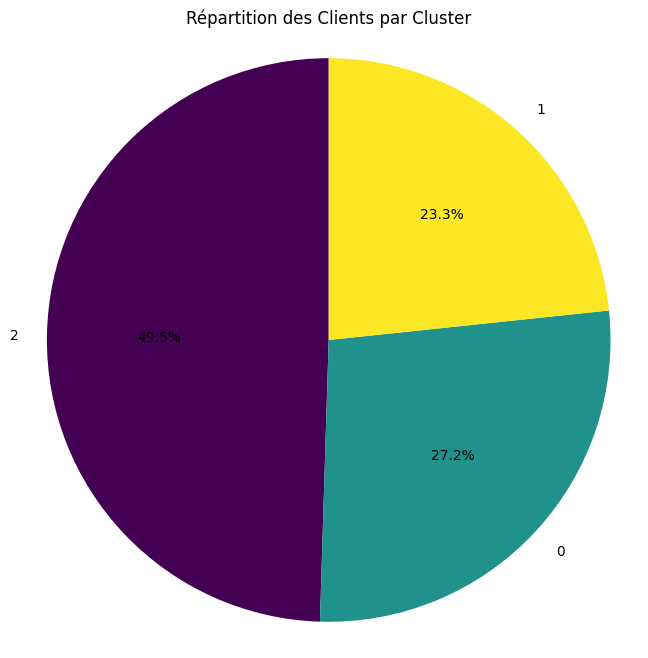

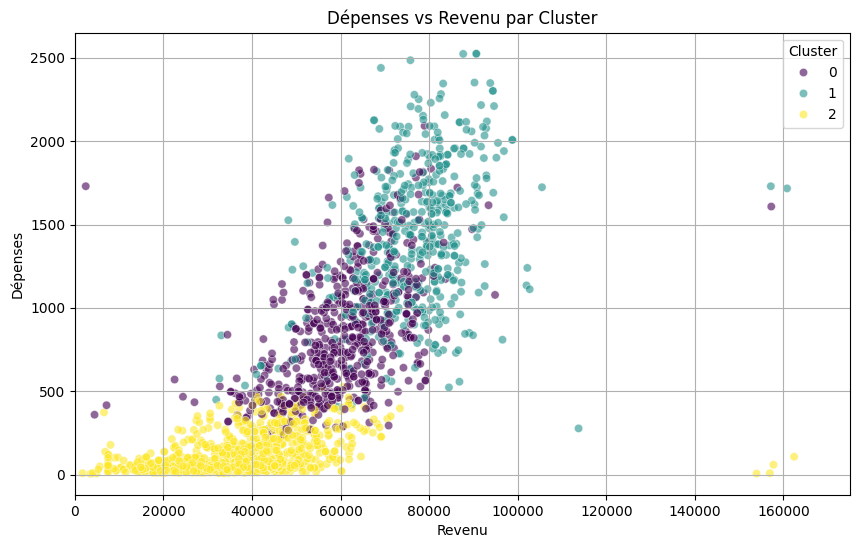

/var/folders/ty/5wqjjz_n4_37mk583lfbl3r80000gn/T/ipykernel_1198/2264925747.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_spent_by_cluster.index, y=mean_spent_by_cluster.values, palette='viridis')


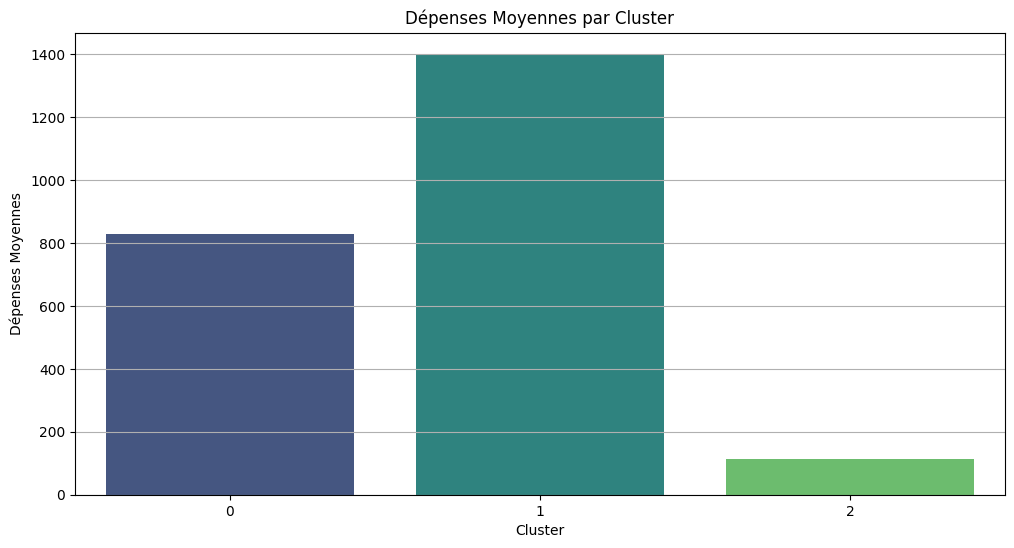

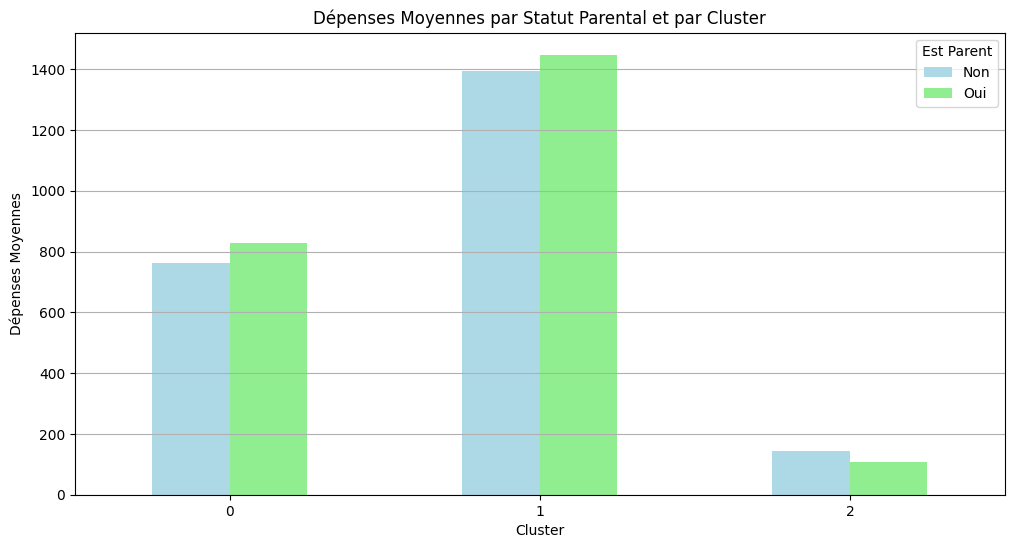

Répartition des clusters sur les différentes campagnes:
         AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
Cluster                                                                         
0            0.038206      0.013289      0.069767      0.132890      0.018272   
1            0.228240      0.038685      0.087041      0.135397      0.292070   
2            0.000912      0.001823      0.069280      0.012762      0.000000   

         Response  
Cluster            
0        0.126246  
1        0.319149  
2        0.083865  


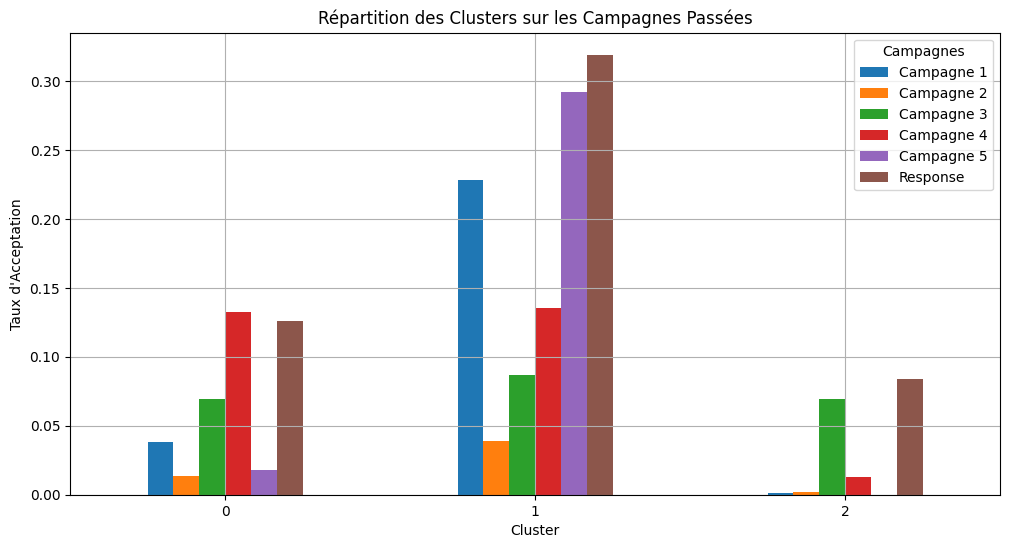

Somme des Dépenses par Type de Produit Groupées par Cluster :
         MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Cluster                                                          
0          295243      18802           100823            24408   
1          323264      33697           241286            50374   
2           57576       5906            27954             8623   

         MntSweetProducts  MntGoldProds  
Cluster                                  
0                   18741         40180  
1                   35238         39468  
2                    5917         17779  


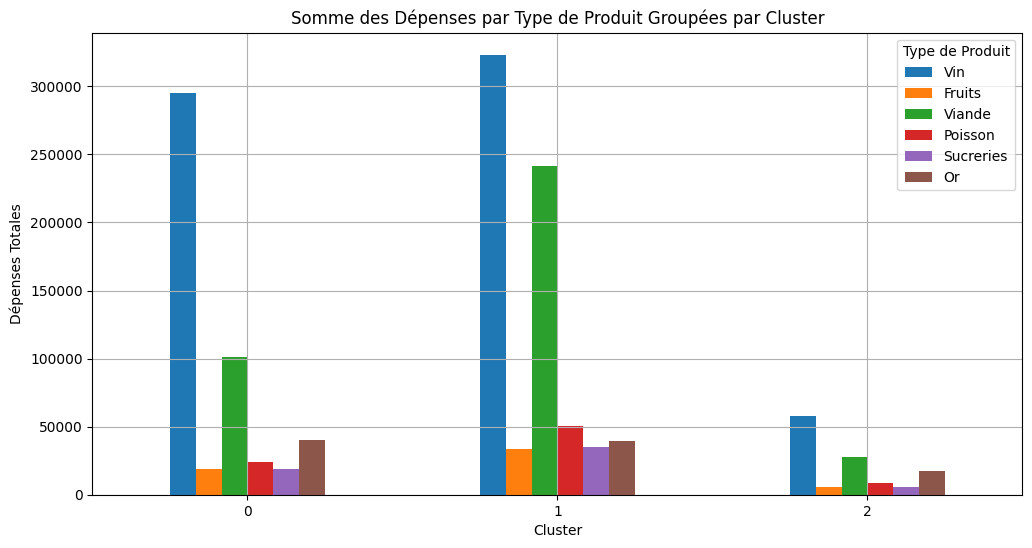

Moyenne des Dépenses par Type de Produit Groupées par Cluster :
           MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Cluster                                                            
0        490.436877  31.232558       167.480066        40.544850   
1        625.268859  65.177950       466.704062        97.435203   
2         52.484959   5.383774        25.482224         7.860529   

         MntSweetProducts  MntGoldProds  
Cluster                                  
0               31.131229     66.744186  
1               68.158607     76.340426  
2                5.393801     16.206928  


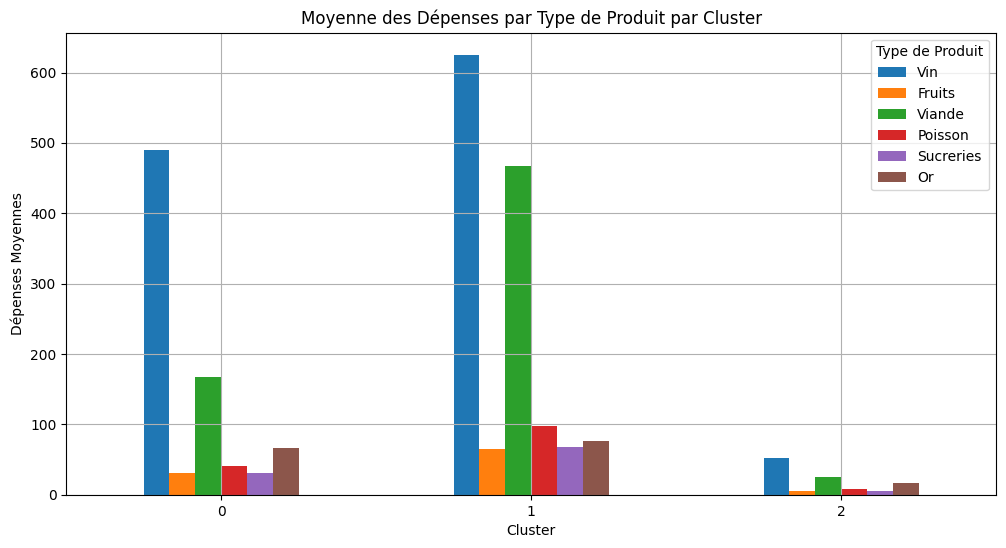

Âge moyen par cluster :
Cluster
0    49.400332
1    46.899420
2    44.072926
Name: age, dtype: float64


/var/folders/ty/5wqjjz_n4_37mk583lfbl3r80000gn/T/ipykernel_1198/2264925747.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_mean_by_cluster.index, y=age_mean_by_cluster.values, palette='viridis')


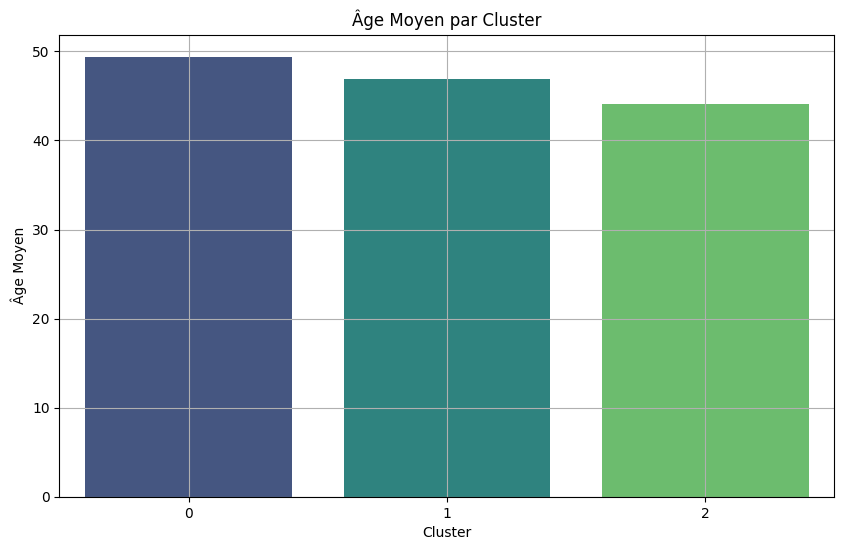

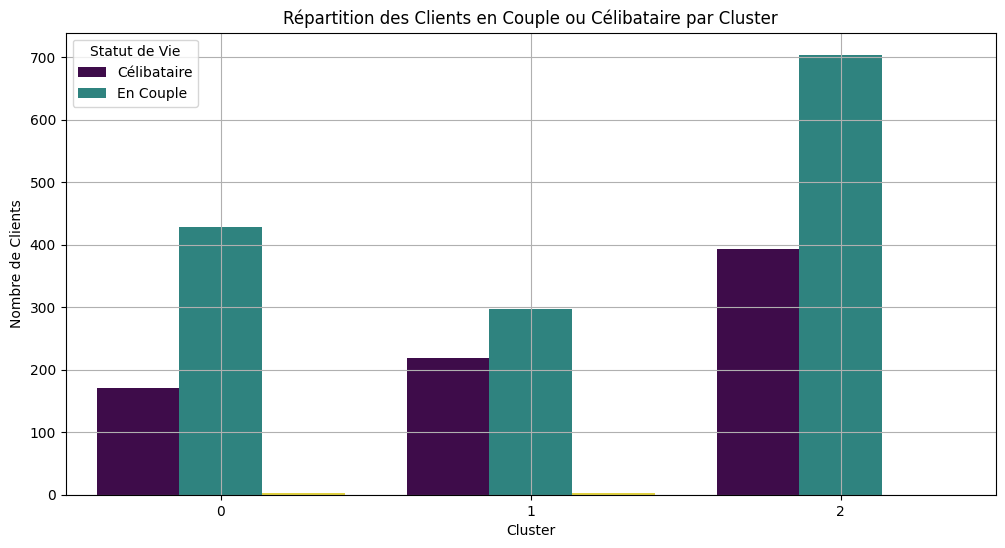

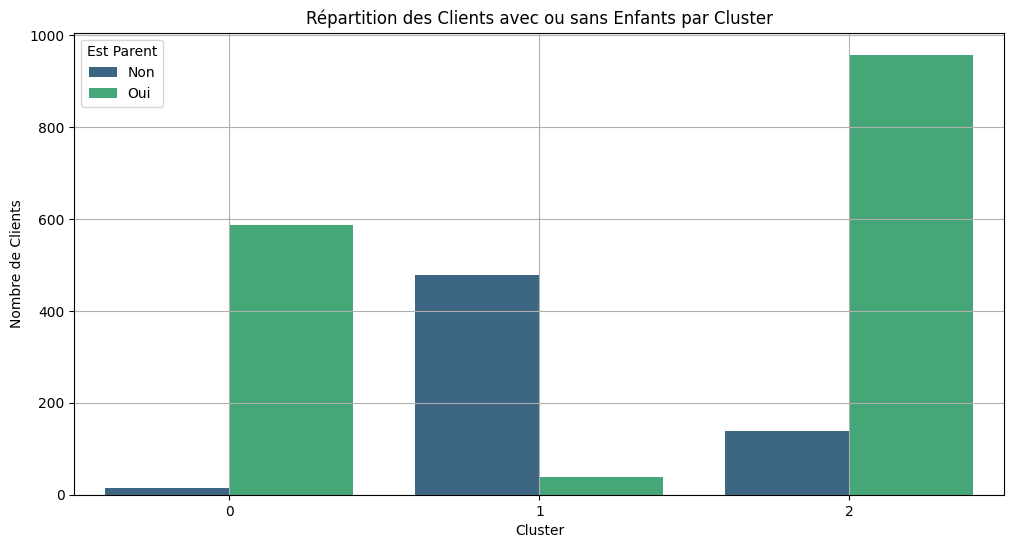

Revenu moyen par cluster :
Cluster
0    61222.546512
1    76319.239845
2    35977.109389
Name: Income, dtype: float64


/var/folders/ty/5wqjjz_n4_37mk583lfbl3r80000gn/T/ipykernel_1198/2264925747.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_mean_by_cluster.index, y=revenue_mean_by_cluster.values, palette='viridis')


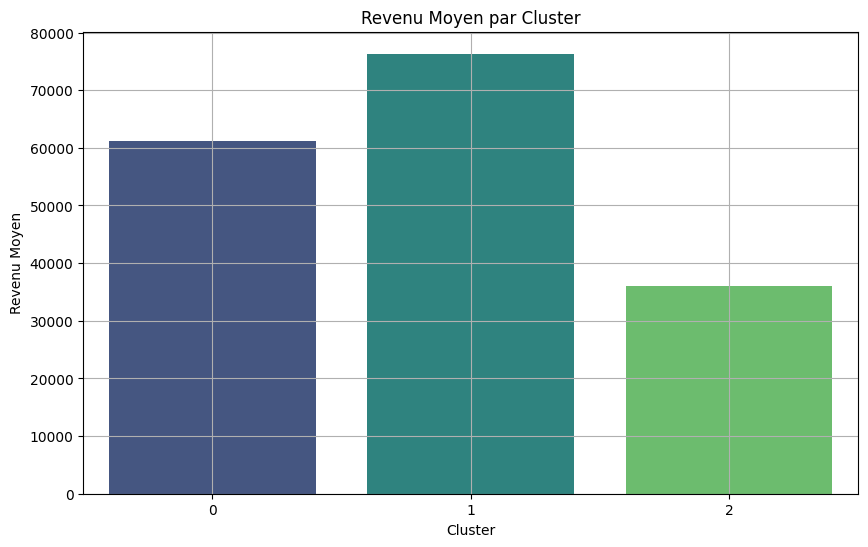

Proportions des statuts par cluster (%):
living_with          0          1         2
Cluster                                    
0            28.405316  71.262458  0.332226
1            42.166344  57.446809  0.386847
2            35.824977  64.175023  0.000000


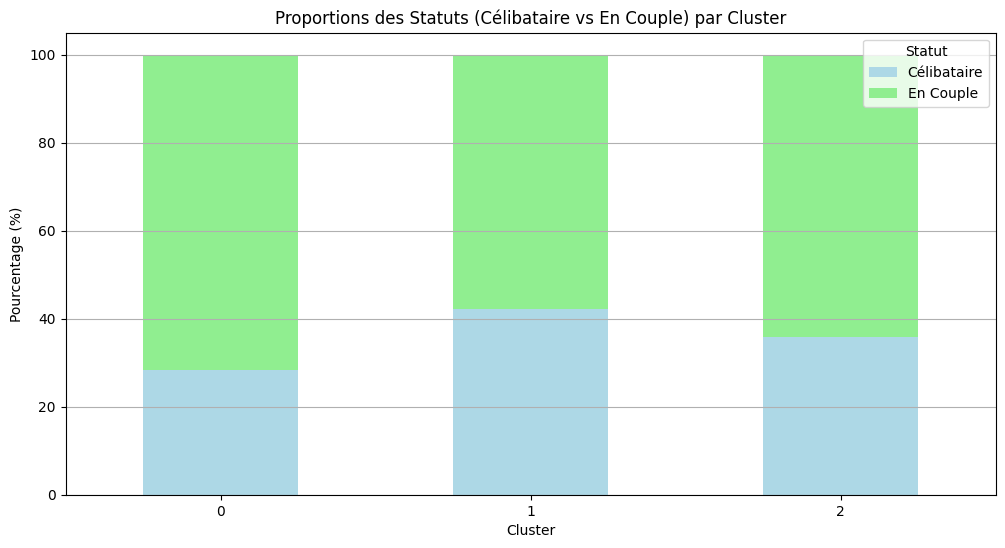

Proportions des niveaux d'éducation par cluster (%):
education2          0          1          2
Cluster                                    
0           51.328904  41.860465   6.810631
1           53.384913  37.524178   9.090909
2           48.404740  36.463081  15.132179


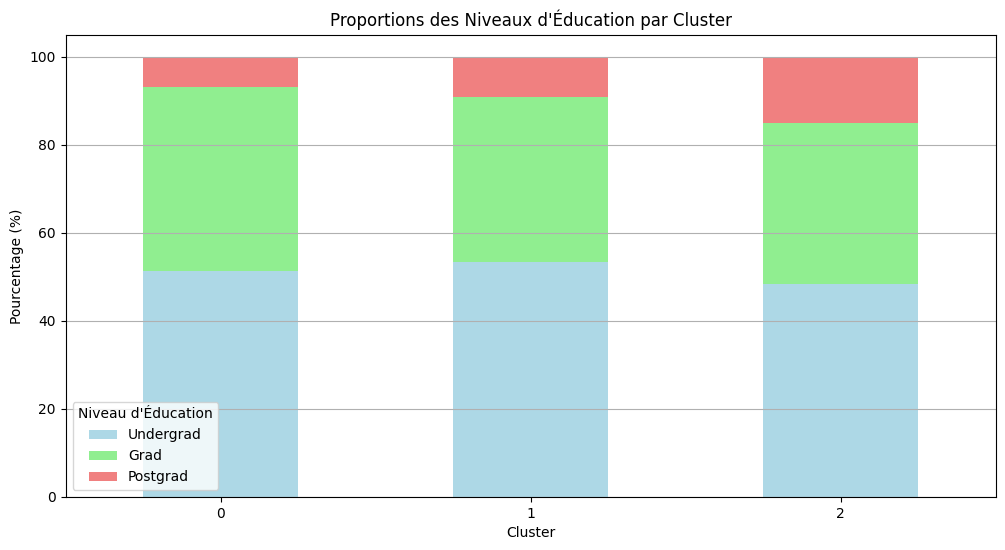

Nombre moyen d'enfants par cluster :
Cluster
0    1.209302
1    0.075435
2    1.214221
Name: children, dtype: float64


/var/folders/ty/5wqjjz_n4_37mk583lfbl3r80000gn/T/ipykernel_1198/2264925747.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_children_by_cluster.index, y=mean_children_by_cluster.values, palette='viridis')


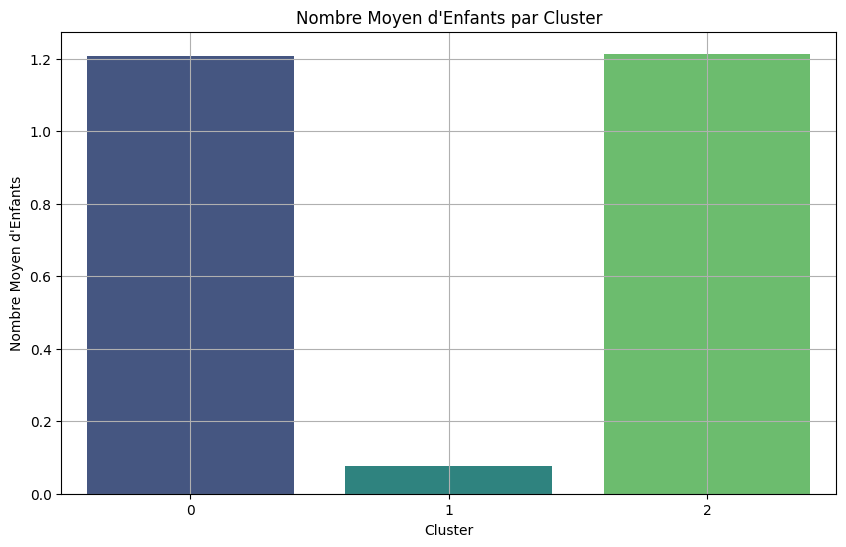

In [33]:
# ---- Évaluation des modèles et interprétation du profil consommateur ----


# Compter le nombre de clients dans chaque cluster
cluster_counts = data['Cluster'].value_counts(normalize=True) * 100

# Visualiser la répartition des clients par cluster avec un diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))))
plt.title('Répartition des Clients par Cluster')
plt.axis('equal')  # Pour un cercle parfait
plt.show()


# Diagramme de dispersion des dépenses vs revenu par cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='spent', hue='Cluster', data=data, palette='viridis', alpha=0.6)
plt.title('Dépenses vs Revenu par Cluster')
plt.xlabel('Revenu')
plt.ylabel('Dépenses')
plt.xlim(0, 175000)  
plt.grid()
plt.legend(title='Cluster')
plt.show()


# Calculer la moyenne des dépenses par cluster
mean_spent_by_cluster = data.groupby('Cluster')['spent'].mean()
# Visualiser les résultats avec un diagramme à barres
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_spent_by_cluster.index, y=mean_spent_by_cluster.values, palette='viridis')
plt.title('Dépenses Moyennes par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Dépenses Moyennes')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


# Calculer la moyenne des dépenses par cluster et par statut parental
mean_spent_by_parent_status = data.groupby(['Cluster', 'is_parent'])['spent'].mean().unstack()
# Visualiser les résultats avec un diagramme à barres
mean_spent_by_parent_status.plot(kind='bar', figsize=(12, 6), color=['lightblue', 'lightgreen'])
plt.title('Dépenses Moyennes par Statut Parental et par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Dépenses Moyennes')
plt.xticks(rotation=0)
plt.legend(title='Est Parent', labels=['Non', 'Oui'])
plt.grid(axis='y')
plt.show()


# Bar Plot pour les Taux d'Acceptation des Campagnes
# Liste des colonnes des campagnes, y compris la colonne 'Response'
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
# Calculer la moyenne des réponses aux campagnes par cluster
campaigns_distribution = data.groupby('Cluster')[campaign_columns].mean()
# Afficher les résultats
print("Répartition des clusters sur les différentes campagnes:")
print(campaigns_distribution)
# Visualiser la répartition
campaigns_distribution.plot(kind='bar', figsize=(12, 6))
plt.title('Répartition des Clusters sur les Campagnes Passées')
plt.xlabel('Cluster')
plt.ylabel('Taux d\'Acceptation')
plt.xticks(rotation=0)
plt.legend(title='Campagnes', labels=['Campagne 1', 'Campagne 2', 'Campagne 3', 'Campagne 4', 'Campagne 5', 'Response'])
plt.grid()
plt.show()


# Somme des Dépenses par Type de Produit Groupées par Cluster
# Liste des colonnes des types de produits dépensés
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
# Calculer la somme des dépenses par type de produit et par cluster
product_distribution = data.groupby('Cluster')[product_columns].sum()
# Afficher les résultats
print("Somme des Dépenses par Type de Produit Groupées par Cluster :")
print(product_distribution)
# Visualiser la répartition
product_distribution.plot(kind='bar', figsize=(12, 6))
plt.title('Somme des Dépenses par Type de Produit Groupées par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Dépenses Totales')
plt.xticks(rotation=0)
plt.legend(title='Type de Produit', labels=['Vin', 'Fruits', 'Viande', 'Poisson', 'Sucreries', 'Or'])
plt.grid()
plt.show()


# Moyenne depense par type de produit et cluster
# Liste des colonnes des types de produits dépensés
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
# Calculer la moyenne des dépenses par type de produit et par cluster
average_product_distribution = data.groupby('Cluster')[product_columns].mean()
# Afficher les résultats
print("Moyenne des Dépenses par Type de Produit Groupées par Cluster :")
print(average_product_distribution)
# Visualiser la répartition avec un graphique à barres
average_product_distribution.plot(kind='bar', figsize=(12, 6))
plt.title('Moyenne des Dépenses par Type de Produit par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Dépenses Moyennes')
plt.xticks(rotation=0)
plt.legend(title='Type de Produit', labels=['Vin', 'Fruits', 'Viande', 'Poisson', 'Sucreries', 'Or'])
plt.grid()
plt.show()


# Calculer l'âge moyen par cluster à partir des données d'origine
age_mean_by_cluster = data.groupby('Cluster')['age'].mean()
# Afficher les résultats
print("Âge moyen par cluster :")
print(age_mean_by_cluster)
# Visualiser l'âge moyen par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=age_mean_by_cluster.index, y=age_mean_by_cluster.values, palette='viridis')
plt.title('Âge Moyen par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Âge Moyen')
plt.xticks(rotation=0)
plt.grid()
plt.show()


# Visualiser la répartition en couple ou célibataire
plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='living_with', data=data, palette='viridis')
plt.title('Répartition des Clients en Couple ou Célibataire par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre de Clients')
plt.legend(title='Statut de Vie', labels=['Célibataire', 'En Couple'])
plt.grid()
plt.show()


# Visualiser la présence d'enfants
plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='is_parent', data=data, palette='viridis')
plt.title('Répartition des Clients avec ou sans Enfants par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre de Clients')
plt.legend(title='Est Parent', labels=['Non', 'Oui'])
plt.grid()
plt.show()


# Calculer le revenu moyen par cluster
revenue_mean_by_cluster = data.groupby('Cluster')['Income'].mean()
# Afficher les résultats
print("Revenu moyen par cluster :")
print(revenue_mean_by_cluster)
# Visualiser le revenu moyen par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_mean_by_cluster.index, y=revenue_mean_by_cluster.values, palette='viridis')
plt.title('Revenu Moyen par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Revenu Moyen')
plt.xticks(rotation=0)
plt.grid()
plt.show()


# Compter le nombre de clients en couple et célibataires par cluster
status_counts = data.groupby(['Cluster', 'living_with']).size().unstack(fill_value=0)
# Calculer les proportions
status_proportions = status_counts.div(status_counts.sum(axis=1), axis=0) * 100
# Afficher les résultats
print("Proportions des statuts par cluster (%):")
print(status_proportions)
# Visualiser les proportions avec un graphique à barres empilées
status_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), color=['lightblue', 'lightgreen'])
plt.title('Proportions des Statuts (Célibataire vs En Couple) par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Pourcentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Statut', labels=['Célibataire', 'En Couple'])
plt.grid(axis='y')
plt.show()


# Proportion des cluster par grad
# Créer un DataFrame pour les proportions
education_distribution = data.groupby(['Cluster', 'education2']).size().unstack(fill_value=0)
# Calculer les proportions
education_proportions = education_distribution.div(education_distribution.sum(axis=1), axis=0) * 100
# Afficher les résultats
print("Proportions des niveaux d'éducation par cluster (%):")
print(education_proportions)
# Visualiser les proportions avec un graphique à barres empilées
education_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Proportions des Niveaux d\'Éducation par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Pourcentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Niveau d\'Éducation', labels=['Undergrad', 'Grad', 'Postgrad'])
plt.grid(axis='y')
plt.show()


# Nombre moyens d'enfant par cluster
# Calculer le nombre moyen d'enfants par cluster
mean_children_by_cluster = data.groupby('Cluster')['children'].mean()
# Afficher les résultats
print("Nombre moyen d'enfants par cluster :")
print(mean_children_by_cluster)
# Visualiser le nombre moyen d'enfants par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_children_by_cluster.index, y=mean_children_by_cluster.values, palette='viridis')
plt.title('Nombre Moyen d\'Enfants par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre Moyen d\'Enfants')
plt.xticks(rotation=0)
plt.grid()
plt.show()






### 8. Analyse  final des données du magasin

Analyse des campagnes marketing : Les taux d'acceptation des différentes campagnes marketing ont varié, allant de 1,35 % à 15 %, ce qui montre un impact limité des campagnes sur une majorité des clients. Cependant, une analyse par segments a révélé des taux de réponse plus élevés pour certaines campagnes dans des clusters spécifiques, suggérant que certains groupes de clients sont plus réceptifs aux offres.

Profilage des clients : En utilisant des techniques de PCA et de clustering (K-Means), trois segments de clients distincts ont été identifiés. Chaque groupe présente des caractéristiques démographiques et comportementales uniques, comme les niveaux de dépenses, l'âge et le statut parental, permettant de mieux comprendre leurs préférences et comportements d'achat.


Cluster 0 :
	•	Pourcentage : 27,2 % du nombre total de clients
	•	Dépense moyenne : 800
	•	Âge moyen : 49 ans
	•	Composition : Majoritairement composé de personnes en couple, avec en moyenne 1 enfant et un revenu moyen de 61 222.


Cluster 1 (groupe de clients qui dépensent le plus) :
	•	Pourcentage : 23,3 % du nombre total de clients
	•	Dépense moyenne : 1 400
		Dépense en moyenne le plus sur toutes les catégories de produits.
	•	Taux d'acceptation : A les meilleurs taux d'acceptation sur toutes les campagnes.
	•	Âge moyen : 47 ans
	•	Composition : Majoritairement composé de personnes en couple (290 en couple contre environ 210 célibataires), avec en moyenne 0 enfant et un revenu moyen de 76 319.


Cluster 2 (groupe de clients qui dépensent le moins) :
	•	Pourcentage : 49,5 % du nombre total de clients
	•	Dépense moyenne : 110
	    Dépense en moyenne le moins sur toutes les catégories de produits.
	•	Taux d'acceptation : A les taux d'acceptation les plus faibles sur toutes les campagnes.
	•	Âge moyen : 44 ans
	•	Composition : Majoritairement composé de personnes en couple, avec en moyenne 1 enfant et un revenu moyen de 35 977.


Stratégies d'amélioration : L'analyse des comportements par cluster offre une piste pour personnaliser les campagnes futures, en ciblant les segments spécifiques avec des offres adaptées, optimisant ainsi l'efficacité des campagnes et améliorant la fidélisation des clients.